In [1]:
import numpy as np
import pandas as pd
import itertools
import math
import scipy.special
import random
import copy

In [2]:
data = pd.read_csv("data/small.csv")
data.head()

,age,portembarked,fare,numparentschildren,passengerclass,sex,numsiblings,survived
0,1,1,1,1,1,1,1,1
1,2,2,1,1,2,2,1,2
2,1,1,1,1,1,2,1,2
3,2,1,1,1,2,2,1,2
4,2,1,1,1,1,1,1,1


In [3]:
def compute_all_combinations(var,parents,data):
    #var is a dict of size 1 with var as key and list of values it can take as value
    #Parents is a dict with parent names as keys and list of values they can take as values
    
    #Finding the different instances (Xi,Parents(Xi))
    
    values = []
    variables = []
    for elem in var.keys():
        values.append(elem)
        variables.append(var[elem])
    for elem in parents.keys():
        values.append(elem)
        variables.append(parents[elem])
    variables = list(itertools.product(*variables))
    #Computing the M_ijk values and storing them
    #There is maybe a faster time to do this check : https://stackoverflow.com/questions/27654474/count-the-tuples-of-a-pandas-dataframe
    #getting the variable and parents names
    var_name = list(var.keys())[0]
    parent_names = list(parents.keys())
    new_data = data[[var_name] + parent_names]
    new_data.head()
    #transforming the dataframe into a list of tuples
    new_data = list(new_data.itertuples(index=False, name=None))
    count_dict={}
    for var in variables:
        count_dict[var] = 0
    for row in new_data:
        count_dict[row] += 1
    return count_dict
            
            
        
        
    

In [4]:
#Testing
var = {"age":[1,2,3]}
parents = {"sex":[1,2],"survived" : [1,2]}

new_data = compute_all_combinations(var,parents,data)
print(new_data)

{(1, 1, 1): 152, (1, 1, 2): 40, (1, 2, 1): 37, (1, 2, 2): 90, (2, 1, 1): 283, (2, 1, 2): 65, (2, 2, 1): 43, (2, 2, 2): 130, (3, 1, 1): 33, (3, 1, 2): 4, (3, 2, 1): 1, (3, 2, 2): 11}


In [5]:
def compute_fixed_parents(var,parent_values,count_dict):
    #Var is a dict with all of the potential values as a value
    #parent_values is a tuple of fixed parent values
    var_name = list(var.keys())[0]
    new_dict = {}
    for elem in var[var_name]:
        new_dict[elem] = 0
    for key in count_dict.keys():
        #Split the tuple to get the x_value and the parent instantiation
        instantiation = key[1:]
        if instantiation == parent_values:
            new_dict[key[0]] += count_dict[key]
    return new_dict
        
    

In [6]:
count_dict = compute_fixed_parents(var,(1,1),new_data)
print(count_dict)

{1: 152, 2: 283, 3: 33}


In [7]:

def first_sum(var,parent_values,count_dict):
    x_counts = compute_fixed_parents(var,parent_values,count_dict)
    m_ij_0 = sum(x_counts.values())
    internal_sum = 0
    for key in x_counts:
        internal_sum += scipy.special.loggamma(1 + x_counts[key])
    #Finding the value of r_i
    var_name = list(var.keys())[0]
    r_i = len(var[var_name])
    internal_sum += (scipy.special.loggamma(r_i) - scipy.special.loggamma(r_i + m_ij_0))
    
    return internal_sum
    
        

In [8]:
print(first_sum(var,(1,1),new_data))

-406.56753981218185


In [9]:
def sum_over_parents(var,parents,data):
    new_data_counts = compute_all_combinations(var,parents,data)
    parent_values = set()
    #Finding all the parents combinations
    for key in new_data_counts.keys():
        extracted_value = key[1:]
        parent_values.add(extracted_value)
    #Computing the outer-internal sum of the score
    ret_sum = 0
    for instantiation in parent_values:
        ret_sum += first_sum(var,instantiation,new_data_counts)
    return ret_sum
        

        
    

In [10]:
import networkx as nx


class BayesianNetwork:
    
    def __init__(self,variables = [],edges = []):
        self.variables = variables
        self.parents = {}
        self.edges = []
        #Creating a dictionary for storing dependency relationships between variables
        for node in variables:
            self.parents[node] = []
        self.add_edges(edges)
            
    #Adding a dependency
    def add_edge(self,edge):
        self.edges.append(edge)
        self.parents[edge[1]].append(edge[0])
    
    
    def add_edges(self,edges):
        for edge in edges:
            self.edges.append(edge)
            self.parents[edge[1]].append(edge[0])

    #Removing a dependency
    def remove_edge(self,edge):
        if edge[0] in self.parents[edge[1]]:
            self.parents[edge[1]].remove(edge[0])
            self.edges.remove(edge)
    

    #Creating a new Bayesian network

    def copy(self):
        return BayesianNetwork(self.variables,self.edges.copy())
    
    def show_network(self):
        nx_graph = nx.DiGraph()
        nx_graph.add_nodes_from(self.variables)
        nx_graph.add_edges_from(self.edges)
        nx.draw(nx_graph,with_labels = True)
        
    
    def __eq__(self,graph):
        set_1 = set(self.edges)
        set_2 = set(graph.edges)
        return set_1 == set_2
        
            
        
    

In [11]:
def get_variable_values(df):
    return {c: list(df[c].unique()) for c in df.columns}
    

In [12]:
def compute_score(network,data,variable_values):
    score = 0
    for variable in variable_values.keys():
        #On a besoin d'un argument {variable_actuelle : valeurs}
        var_dict = {}
        var_dict[variable] = variable_values[variable]
        #Et d'un autre arguments {parents de la variable : leur valeurs}
        parents_dict = {}
        for parent in network.parents[variable]:
            parents_dict[parent] = variable_values[parent]
        score += sum_over_parents(var_dict,parents_dict,data)
    return score
        
            
        

In [13]:
#Test 
print(get_variable_values(data))

{'age': [1, 2, 3], 'portembarked': [1, 2, 3], 'fare': [1, 2, 3], 'numparentschildren': [1, 2, 3], 'passengerclass': [1, 2, 3], 'sex': [1, 2], 'numsiblings': [1, 2, 3], 'survived': [1, 2]}


In [14]:
variable_values = get_variable_values(data)
network = BayesianNetwork(list(variable_values.keys()),[("age","sex"),("numsiblings","survived")])
print("we here")
compute_score(network,data,variable_values)

we here


-4163.79120315116

In [15]:
def has_cycle(network,added_edge,reverse = False):
    graph = {}
    for elem in network.parents.keys():
        graph[elem] = []
        for elem_2 in network.parents[elem]:
            graph[elem].append(elem_2)
    if reverse: #If reversing the graph, we need to remove the edge from the adjacency list before adding
                #its reverse
        graph[added_edge[0]].remove(added_edge[1])
        graph[added_edge[1]].append(added_edge[0])
    else:
        #If we add an edge
        graph[added_edge[1]].append(added_edge[0])
    visited = set()
    stack = set()
    # DFS function
    def dfs(node):
        visited.add(node)
        stack.add(node)
        if node in graph:
            for parent in graph[node]:
                if parent not in visited:
                    if dfs(parent):
                        return True
                elif parent in stack:
                    return True
        stack.remove(node)
        return False
    # Check for cycles
    for node in graph:
        if node not in visited:
            if dfs(node):
                return True
    return False

def get_new_network(network):
        #Choosing from either deleting an edge or adding one
        i = random.randint(0,2)
        new_network = network.copy()
        #Adding an edge
        u , w = random.randint(0,len(network.variables) - 1),random.randint(0,len(network.variables) - 1)
        if i == 0 or (len(network.edges) == 0):
            simple_digraph = False
            while(True):
                u , w = random.randint(0,len(network.variables) - 1),random.randint(0,len(network.variables) - 1)
                #Checking if it's a new edge
                if (network.variables[u] not in network.parents[network.variables[w]]):
                    #Checking if it's not a loop and that it does not create a cycle
                    if ((u != w) and not(has_cycle(network,(network.variables[u],network.variables[w])))):
                        new_network.add_edge((network.variables[u],network.variables[w]))
                        break
        #Deleting an edge
        elif i == 1:
            while(network.variables[u] not in network.parents[network.variables[w]]):
                u , w = random.randint(0,len(network.variables) - 1),random.randint(0,len(network.variables) - 1)
            new_network.remove_edge((network.variables[u],network.variables[w]))
        #Reversing an edge
        else:
            visited = set()
            #Choosing a random edge to reverse
            while(True):
                if len(visited) == len(network.edges):
                    return network
                i = random.randint(0,len(network.edges)-1)
                var_1,var_2 = network.edges[i]
                if (var_1,var_2) in visited:
                    continue
                visited.add((var_1,var_2))
                #Checking if reversing an edge does not create a cycle
                if not(has_cycle(network,(var_2,var_1),reverse = True)):
                    new_network.remove_edge(network.edges[i])
                    new_network.add_edge((var_2,var_1))
                    break
        return new_network
            
                

In [16]:
new_network = get_new_network(network)

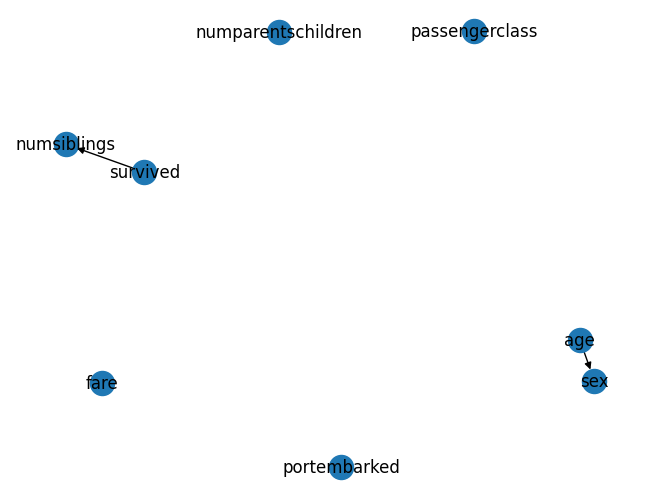

In [17]:
new_network.show_network()

In [18]:
compute_score(new_network,data,variable_values)

-4168.087584354465

In [19]:
def acceptance_probability(old_score, new_score, temperature):
    if new_score > old_score:
        return 1.0
    else:
        return np.exp((new_score - old_score) / temperature)


def bn_simulated_annealing(data,init_network,temperature = 1000,cooling_rate = 0.95,max_iterations = 1000):
    variable_values = get_variable_values(data)
    current_network = init_network.copy()
    current_score = compute_score(current_network,data,variable_values)
    print(current_score)
    visited_graphs = set()
    for i in range(max_iterations):
        if (i % 10 == 0):
            #print("iteration",i)
            pass
        new_network = get_new_network(current_network)
        new_score = compute_score(new_network,data,variable_values)
        
        prob = acceptance_probability(current_score, new_score, temperature)
        rand = np.random.rand()
        if  rand < prob:
            current_network = new_network
            current_score = new_score
            #print(current_score)
        temperature *= cooling_rate
    print("optimal network score",current_score)
    return current_network
    

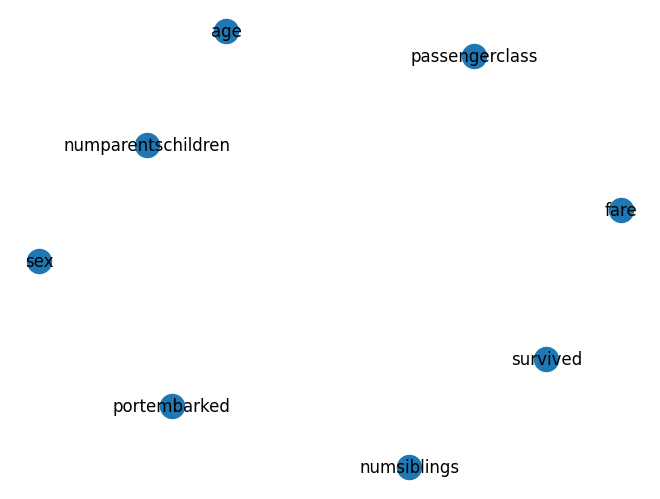

In [20]:
other_network = BayesianNetwork(variables = list(variable_values.keys()))
other_network.show_network()

In [21]:
optimal_network = bn_simulated_annealing(data, other_network)

-4166.225858784904
optimal network score -3801.0173694487244


In [22]:
import bnlearn as bn

# Load dataframe
# Pre-processing of the input dataset
dfhot, dfnum = bn.df2onehot(data)

# Structure learning
DAG = bn.structure_learning.fit(dfnum)

# Plot
G = bn.plot(DAG)

ModuleNotFoundError: No module named 'bnlearn'

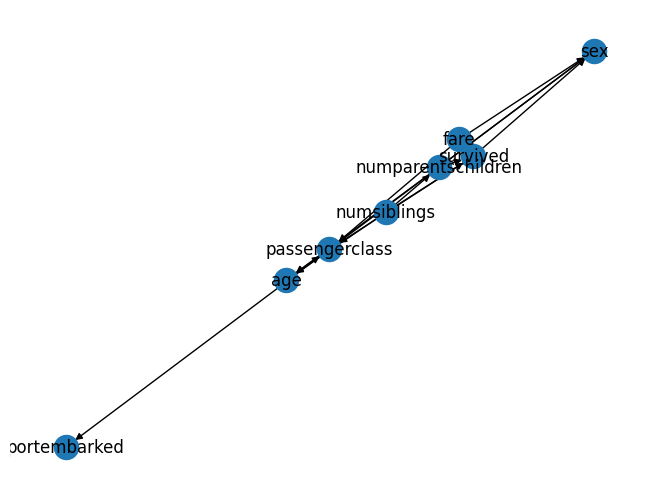

In [25]:
optimal_network.show_network()

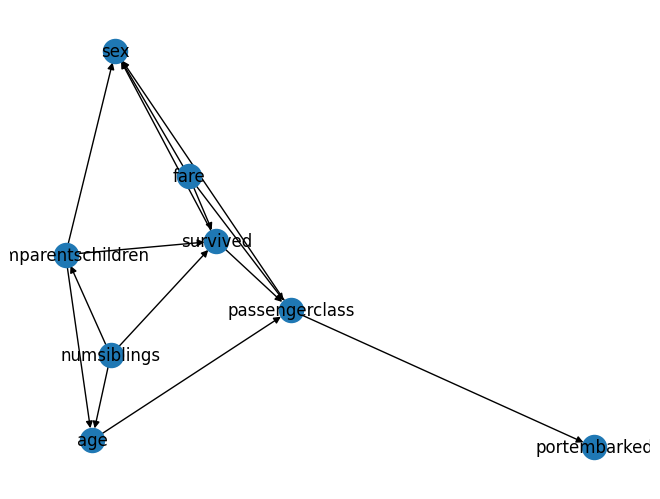

In [26]:
optimal_network.show_network()

In [27]:
print(optimal_network.parents['sex'])

['numparentschildren', 'fare', 'survived', 'passengerclass']


In [28]:
class TPC:
    
    def __init__(self,network,data):
        self.network = network
        self.data = data
        self.table = {}
        variable_values = get_variable_values(data)
        # create a dictionary as key : node and value : dictionary of TPC
        for node in variable_values.keys(): #age
            node_dict = {}
            node_dict[node] = variable_values[node]
            parents_dict = {}
            for parent in network.parents[node]:
                parents_dict[parent] = variable_values[parent]
            dico = compute_all_combinations(node_dict,parents_dict,data) 
            parent_values = set()
            #Finding all the parents combinations
            for key in dico.keys():
                extracted_value = key[1:]
                parent_values.add(extracted_value)
            parent_dict={}
            # parent_dict : dictionary with key : tuple of parent and value : number of presence
            for parent in parent_values :
                count_dict = compute_fixed_parents(node_dict,parent,dico)
                total = 0
                for key in count_dict.keys():
                    total += count_dict[key]
                parent_dict[parent]=total #dico avec clé le tuple de valeur de parent et valeur le nombre de fois ou ca apparait
            dico_proba={}
            #dictionary with key : tuple of variable and its parents and value : proba 
            for last_key in dico.keys():
                total = parent_dict[last_key[1:]]
                if total == 0 :
                    proba = 0
                else:
                    proba = dico[last_key]/total
                dico_proba[last_key]=proba
            self.table[node]= dico_proba
    
    
    def show_table(self,variable):
        first_line = ""
        first_line += variable
        first_line += " "
        for elem in self.network.parents[variable]:
            first_line += (elem + ' ')
        print(first_line)
        for key in self.table[variable].keys():
            print(key,self.table[variable][key])

In [29]:
tpc = TPC(optimal_network,data)
tpc.show_table('age')

age numparentschildren numsiblings 
(1, 1, 1) 0.3234536082474227
(1, 1, 2) 0.6666666666666666
(1, 1, 3) 0
(1, 2, 1) 0.6140350877192983
(1, 2, 2) 1.0
(1, 2, 3) 0.0
(1, 3, 1) 0.0
(1, 3, 2) 0
(1, 3, 3) 0
(2, 1, 1) 0.6172680412371134
(2, 1, 2) 0.3333333333333333
(2, 1, 3) 0
(2, 2, 1) 0.3508771929824561
(2, 2, 2) 0.0
(2, 2, 3) 1.0
(2, 3, 1) 0.9
(2, 3, 2) 0
(2, 3, 3) 0
(3, 1, 1) 0.059278350515463915
(3, 1, 2) 0.0
(3, 1, 3) 0
(3, 2, 1) 0.03508771929824561
(3, 2, 2) 0.0
(3, 2, 3) 0.0
(3, 3, 1) 0.1
(3, 3, 2) 0
(3, 3, 3) 0


In [48]:
class Proba:

    def __init__(self,variable, donnee, tpc, data, network):
        self.variable = variable
        self.donnee = donnee # {"age" : 3, "sex": 2 ...}
        self.network = network
        self.parent = self.network.parents[variable] #[sex, age, ..]
        self.data = data
        self.tpc= tpc
        self.prob_parent={}
        variable_values = get_variable_values(data)
        # Make a dictionary with as a key : tuple of variable and its parents, as value : value of proba
        for i in variable_values[variable]: #pour chaque valeur de survived
            x= []
            # Finding tuple of parents's value of variable
            for p in self.parent:
                x += [self.donnee[p]] 
            tupple = tuple([i]+x) 
            self.prob_parent[i] = self.tpc.table[variable][tupple] 

        #Finding children of the variable
        self.children = []
        for key in self.network.parents.keys():
            if variable in self.network.parents[key]:
                self.children.append(key)

        # Calculate P(variable| parent) thanks to the Couverture de Markov
        for i in variable_values[variable]:
            for enfant in self.children :
                x= []
                for p in self.network.parents[enfant]:
                    if p not in self.donnee.keys():
                        x+= [i]
                    else :
                        x += [self.donnee[p]] # pour recup le tuple de valeur de parent de enfant
                tupple = tuple([self.donnee[enfant]]+x) #pour avoir la bonne forme (1,2,1) de enfant et ses parents
                self.prob_parent[i] *= self.tpc.table[enfant][tupple] #dico ave clé tuple et valeur proba
        total=0
        index = 0
        normaliser = 0
        # To find the proba maximal and the value of variable
        for i in self.prob_parent.keys():
                normaliser += self.prob_parent[i]
                if self.prob_parent[i]>total:
                    total = self.prob_parent[i]
                    index = i
        self.max = index 
        self.value_max = total/normaliser #le survived qui donne la bonne proba et on normalise en meme temps





In [51]:
donnee = {"age" :2,"portembarked" : 2,"fare" : 1,"numparentschildren" : 1,"passengerclass" : 2,"sex" : 2,"numsiblings" : 1}
prob = Proba("survived", donnee, tpc, data, optimal_network)
print(prob.value_max)

0.9871701455316872


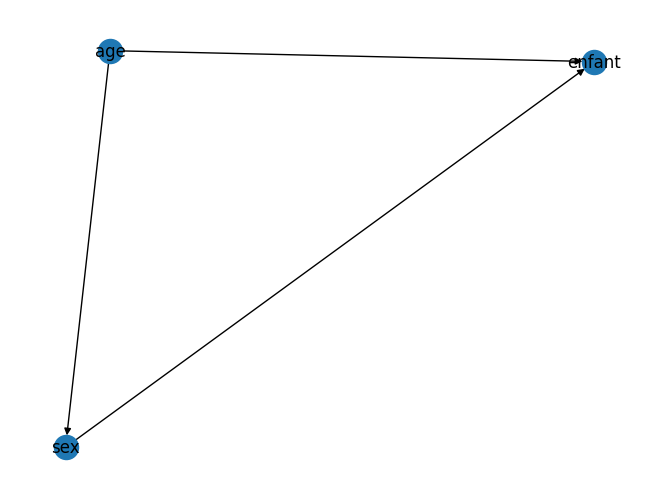

In [32]:
data2 = pd.read_csv("data/test.csv")
variable_values = get_variable_values(data2)
other_network = BayesianNetwork(list(variable_values.keys()),[("age","sex"),("age","enfant"),("sex","enfant")])

other_network.show_network()


In [33]:
tpc2= TPC(other_network,data2)
for var in tpc2.table:
    tpc2.show_table(var)

age 
(1,) 0.75
(2,) 0.25
sex age 
(2, 1) 0.6666666666666666
(2, 2) 0.0
(3, 1) 0.0
(3, 2) 1.0
(1, 1) 0.3333333333333333
(1, 2) 0.0
enfant age sex 
(3, 1, 2) 1.0
(3, 1, 3) 0
(3, 1, 1) 0.0
(3, 2, 2) 0
(3, 2, 3) 0.0
(3, 2, 1) 0
(1, 1, 2) 0.0
(1, 1, 3) 0
(1, 1, 1) 0.0
(1, 2, 2) 0
(1, 2, 3) 1.0
(1, 2, 1) 0
(2, 1, 2) 0.0
(2, 1, 3) 0
(2, 1, 1) 1.0
(2, 2, 2) 0
(2, 2, 3) 0.0
(2, 2, 1) 0


In [34]:
dd = {'age':1,'enfant':2}
pb = Proba("sex", dd, tpc2, data2, other_network)

In [35]:
#Implémentation du Naïve Bayes

def naive_bayes(target_name,data): #Returns a Bayesian network after specifying the target
    variables = list(get_variable_values(data).keys())
    edges = []
    for variable in variables:
        if variable != target_name:
            edges.append((target_name,variable))
    network = BayesianNetwork(variables,edges)
    return network,TPC(network,data)


In [39]:
naive_net,naive_tpc = naive_bayes('survived',data)

survived 
(1,) 0.6175478065241845
(2,) 0.38245219347581555


In [40]:
def predict(network,row,tpc,data,target_name):
    p = Proba(target_name, row, tpc, data, network)
    return p.max

In [58]:
from sklearn.model_selection import train_test_split

def split_and_compare(data,test_size,target_name):
    #Splitting the data
    train,test = train_test_split(data, test_size=test_size)
    #Finding the Bayesian network from the train data using simulated annealing
    variable_values = get_variable_values(data)
    network = BayesianNetwork(variables = list(variable_values.keys()))
    optimal_network = bn_simulated_annealing(train,network)
    opt_tpc = TPC(optimal_network,train)
    #Creating the Bayesian network and its TPC from the train partition
    naive_net,naive_tpc = naive_bayes(target_name,train)
    #Computing accuracies for the two different models
    #Transforming the test df to a list of dictionaries to get the Proba prediction
    test_dict = train.to_dict('records')
    opt_accuracy = 0
    naive_accuracy = 0
    total = len(test_dict)
    for row in test_dict:
        true_value = row.pop(target_name)
        opt_prediction = predict(optimal_network,row,opt_tpc,data,target_name) 
        print("opt prediction",opt_prediction)
        if opt_prediction == true_value:
            opt_accuracy += 1
        naive_prediction = predict(naive_net,row,naive_tpc,data,target_name)
        print("naive prediction",naive_prediction)
        if naive_prediction == true_value:
            naive_accuracy += 1
    print("Bayesian network accuracy",opt_accuracy / total)
    print("Naive assumption accuracy",naive_accuracy / total)
    return optimal_network
    
    
    

In [44]:
net = split_and_compare(data,0.2,'survived')

-3354.4960674842987
optimal network score -3062.328861158529
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 2
naive prediction 2
opt prediction 2
naive prediction 2
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 2
naive prediction 2
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 2
naive prediction 2
opt prediction 1
naive prediction 1
opt prediction 2
naive prediction 2
opt prediction 2
naive prediction 2
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 2
naive prediction 2
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt prediction 1
naive prediction 1
opt

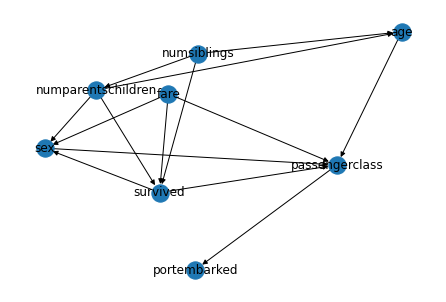

In [ ]:
net.show_network()

-45367.62511363244
optimal network score -42007.16254290178


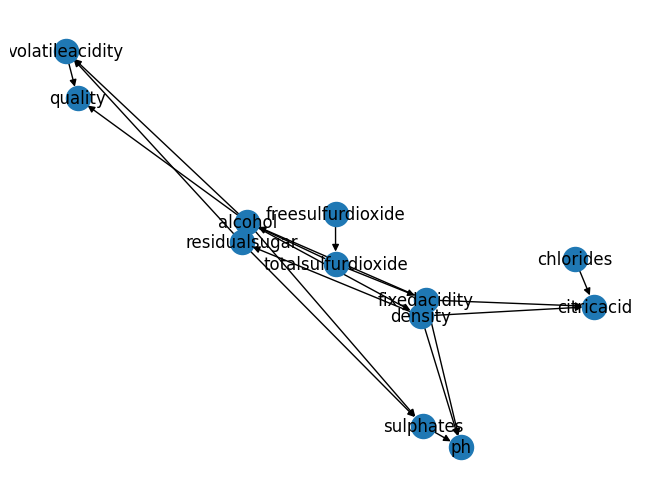

In [54]:
data_wine = pd.read_csv("data/medium.csv")
variable_values_wine = get_variable_values(data_wine)
network_wine = BayesianNetwork(list(variable_values_wine.keys()))
optimal_network_wine = bn_simulated_annealing(data_wine, network_wine)
optimal_network_wine.show_network()



In [56]:
print(optimal_network_wine.parents)



{'fixedacidity': ['totalsulfurdioxide'], 'volatileacidity': ['alcohol', 'residualsugar'], 'citricacid': ['density', 'chlorides', 'fixedacidity'], 'residualsugar': ['density'], 'chlorides': [], 'freesulfurdioxide': [], 'totalsulfurdioxide': ['freesulfurdioxide'], 'density': ['alcohol'], 'ph': ['density', 'fixedacidity', 'sulphates'], 'sulphates': ['alcohol', 'residualsugar'], 'alcohol': ['fixedacidity', 'totalsulfurdioxide'], 'quality': ['alcohol', 'volatileacidity']}


In [59]:
net_wine = split_and_compare(data_wine,0.2,'quality')

-36484.239555212385
optimal network score -33788.05766754682
opt prediction 3
naive prediction 3
opt prediction 3
naive prediction 3
opt prediction 3
naive prediction 3
opt prediction 3
naive prediction 3
opt prediction 3
naive prediction 3
opt prediction 3
naive prediction 3
opt prediction 3
naive prediction 4
opt prediction 3
naive prediction 2
opt prediction 2
naive prediction 2
opt prediction 3
naive prediction 3
opt prediction 2
naive prediction 2
opt prediction 2
naive prediction 2
opt prediction 2
naive prediction 2
opt prediction 3
naive prediction 4
opt prediction 3
naive prediction 4
opt prediction 3
naive prediction 3
opt prediction 4
naive prediction 4
opt prediction 3
naive prediction 3
opt prediction 2
naive prediction 2
opt prediction 2
naive prediction 2
opt prediction 3
naive prediction 2
opt prediction 3
naive prediction 2
opt prediction 3
naive prediction 3
opt prediction 3
naive prediction 3
opt prediction 3
naive prediction 2
opt prediction 3
naive prediction 3
opt